In [2]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
sns.set(color_codes=True)

# Visualize result

### 1. Load results

In [52]:
feature_set = {'None': 'F-0', 
               'skipgram_ce_nm_ws_60_dim_100_epoch_1': 'F-SMF-1', 
               'skipgram_ce_nm_ws_180_dim_100_epoch_1': 'F-SMF-3',
               'skipgram_ce_nm_ws_360_dim_100_epoch_1': 'F-SMF-6',
               'RF': 'RF'}
los_set = {'95-percentile': 'G-2',
           '90-percentile': 'G-3',
           '30-percentile': 'G-5',
           '10-percentile': 'G-11',}
test_score_names = ['test_acc', 
                    'test_ami', 
                    'test_ari',] 
#                     'test_mi', 'test_mmi', 'test_v_measure']
rf_acc_result = {'G-2': 95.07, 'G-3': 80.57, 'G-5': 45.11, 'G-11': 27.52}

In [4]:
def rename_pretrained_path(x):
    if pd.isna(x):
        return feature_set['None']
    else:
        name = x.split('/')[-1].split('.')[0]
        return feature_set[name]

In [53]:
# get all result files
result_dir = '../backup'
result_paths = [join(result_dir, f) for f in listdir(result_dir)
                if isfile(join(result_dir, f)) and 'grid_search_result' in f]
print('result_paths: ', result_paths)

# load to dataframe
df = pd.concat([pd.read_csv(result_path) for result_path in result_paths], ignore_index=True)

# rename
df['pretrained_path'] = df['pretrained_path'].apply(rename_pretrained_path)
df['los_group'] = df['los_group'].apply(lambda x: los_set[x])
df['epoch'] = df['epoch'].apply(lambda x: str(x))
df['test_acc'] = df['test_acc'].apply(lambda x: x * 100)
df['train_acc'] = df['train_acc'].apply(lambda x: x * 100)
print('shape: ', df.shape)

# df.head()

result_paths:  ['../backup/grid_search_result_95percentile.csv', '../backup/grid_search_result_30percentile.csv', '../backup/grid_search_result_90percentile.csv', '../backup/grid_search_result_10percentile.csv']
shape:  (87, 16)


In [54]:
# keep the max accuracy for each los_group, pretrained_path
df.sort_values('epoch', inplace=True)
max_accuracy_groups =  df.groupby(['los_group', 'pretrained_path'])['test_acc'].max()
best_acc_rows = list()
for _, row in df.iterrows():
    if len(max_accuracy_groups) == 0:
        break
    for name in max_accuracy_groups.index:
        if row['los_group'] == name[0] and row['pretrained_path'] == name[1] \
            and row['test_acc'] == max_accuracy_groups.loc[name]:
            best_acc_rows.append(row)
            max_accuracy_groups.drop(name, inplace=True)
            break
best_acc_df = pd.DataFrame(best_acc_rows)
print(best_acc_df.shape)

(16, 16)


In [55]:
# append RF result
for los_group in rf_acc_result.keys():
    best_acc_df = best_acc_df.append({'los_group': los_group, 
                        'pretrained_path': 'RF', 
                        'test_acc': rf_acc_result[los_group]}, ignore_index=True)

In [56]:
best_acc_df.sort_values(['los_group', 'pretrained_path'], inplace=True)
best_acc_df.head(20)

,avg_loss,epoch,los_group,pretrained_path,test_acc,test_ami,test_ari,test_mi,test_mmi,test_v_measure,train_acc,train_ami,train_ari,train_mi,train_mmi,train_v_measure
5,2.236461,1,G-11,F-0,19.918145,9.163837e-02,0.065476,2.223034e-01,1.200029e-01,1.165722e-01,18.705830,0.052261,0.043181,0.126723,0.064443,0.063399
4,2.242073,1,G-11,F-SMF-1,20.623171,7.770238e-02,0.055484,1.893834e-01,1.103604e-01,1.050587e-01,18.190483,0.044408,0.033226,0.108364,0.054113,0.053395
14,2.045535,5,G-11,F-SMF-3,21.053538,9.211694e-02,0.066899,2.249353e-01,1.035990e-01,1.032591e-01,24.239314,0.102041,0.067252,0.244017,0.111217,0.110926
10,2.137109,3,G-11,F-SMF-6,21.604407,8.337546e-02,0.070214,2.031853e-01,1.033017e-01,1.016518e-01,21.335875,0.079621,0.051992,0.191265,0.092849,0.092003
19,NaN,NaN,G-11,RF,27.520000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.344011,1,G-2,F-0,94.508521,2.609345e-16,0.000000,5.551115e-17,5.551115e-07,5.218690e-16,94.896987,-0.000056,0.001616,0.000024,0.000777,0.000238
3,0.202017,1,G-2,F-SMF-1,94.508521,2.609345e-16,0.000000,5.551115e-17,5.551115e-07,5.218690e-16,94.918982,-0.000062,-0.000415,0.000011,0.000561,0.000113
6,0.199299,1,G-2,F-SMF-3,94.508521,2.609345e-16,0.000000,5.551115e-17,5.551115e-07,5.218690e-16,94.896987,-0.000047,-0.000826,0.000023,0.000824,0.000224
2,0.200101,1,G-2,F-SMF-6,94.508521,2.609345e-16,0.000000,5.551115e-17,5.551115e-07,5.218690e-16,94.911650,0.000037,0.001896,0.000040,0.001429,0.000388
16,NaN,NaN,G-2,RF,95.070000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.  Evaluate the effectiveness of Skip-MF

In [7]:
def visual_effective_skipmf(all_data, los_groups, score='test_acc', ylabel='', fname=None):
    # x: pretrained_path, y: accuracy, ami, ari
    
    nrows = 2
    ncols = int(len(los_groups)/2)
    f, axes = plt.subplots(nrows, ncols, figsize=(10, 8))
    plt.subplots_adjust(wspace=0.3, hspace=0.35)
    
    for index, los_group in enumerate(los_groups):
        # filter data
        data = []
        for record in all_data[(all_data.los_group == los_group)].to_dict('records'):
            pretrained_id = record['pretrained_path'].split('-')[-1]
            data.append((pretrained_id, record['pretrained_path'], record[score]))
        data.sort(key=lambda x: x[0])
        x_values = [x[1] for x in data]
        y_values = [x[2] for x in data]
        
        ax = axes[int(index / nrows), index % ncols]
        sns_plot = sns.lineplot(x=x_values, y=y_values, palette="tab10", ax=ax)
        ax.set_ylabel(ylabel)
        ax.set_xlabel('%s' % los_group)
        ax.set_xticklabels(x_values)

    if fname is not None:
        f.savefig(fname)

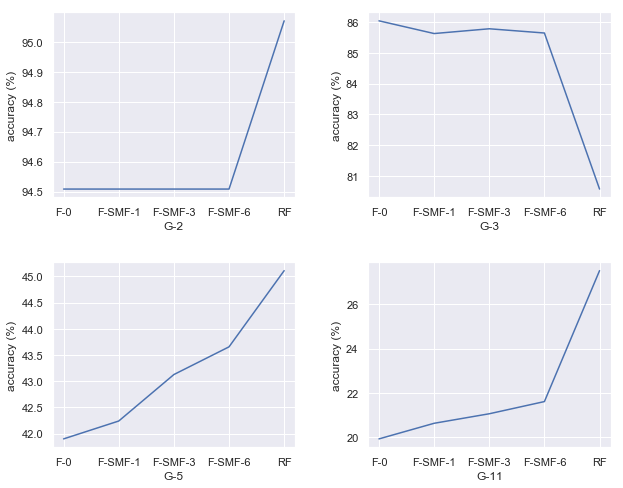

In [57]:
visual_effective_skipmf(best_acc_df, los_groups=los_set.values(), score='test_acc',
                        ylabel="accuracy (%)", fname='../backup/effective_skipmf_acc.png')

In [290]:
# visual_effective_skipmf(best_acc_df, los_groups=los_set.values(), score='test_ami',
#                         ylabel='AMI score', fname='../backup/effective_skipmf_ami.png')

In [289]:
# visual_effective_skipmf(best_acc_df, los_groups=los_set.values(), score='test_ari',
#                         ylabel='ARI score', fname='../backup/effective_skipmf_ari.png')

### 3. Evaluate the effectiveness of different LOS groups
- x : los_group, y: scores

In [50]:
def visual_effective_los_groups(all_data, pretrained_paths, score='test_acc', xlabel=None, ylabel='', fname=None):
    # x : los_group, y: scores (accuracy, ami, ari)
    
    los_group_values = [int(g.split('-')[1]) for g in los_set.values()]
    
    # filter data
    list_data = []
    for index, row in all_data.iterrows():
        list_data.append({'los_group': int(row['los_group'].split('-')[1]),
                          row['pretrained_path']: row['test_acc']})
    data = pd.DataFrame(list_data)
    data.sort_values('los_group', inplace=True)
    data.set_index('los_group', inplace=True)
#     print(data)
    
    sns_plot = sns.lineplot(data=data, palette="tab10", markers=True)
    sns_plot.set_ylabel(ylabel)
    if xlabel is not None:
        sns_plot.set_xlabel(xlabel)
    sns_plot.set_xticks(sorted(los_group_values))
    
    f = sns_plot.get_figure()
    f.set_figure((12,12))
    f.show()

    if fname is not None:
        f.savefig(fname)

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


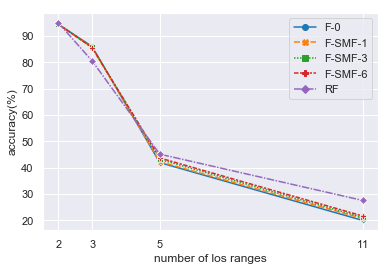

In [58]:
visual_effective_los_groups(best_acc_df, pretrained_paths=feature_set.values(), score='test_acc',
                            xlabel = 'number of los ranges', ylabel='accuracy(%)',
                            fname='../backup/effective_los_groups_acc.png')

## 4.  Evaluate the effectiveness of different window size

In [11]:
def visual_effective_window_size(all_data, score='test_acc', ylabel='', fname=None):
    # x : window size, y: scores (accuracy, ami, ari)
    
    # filter data
    window_sizes = {'F-SMF-1': 60,
                    'F-SMF-3': 180,
                    'F-SMF-6': 360}
    list_data = []
    for index, row in all_data.iterrows():
        if row['pretrained_path'] in window_sizes:
            list_data.append({'window size': window_sizes[row['pretrained_path']],
                              row['los_group']: row['test_acc']})
    data = pd.DataFrame(list_data)
    data.sort_values('window size', inplace=True)
    data.set_index('window size', inplace=True)
#     print(data)
    
    sns_plot = sns.lineplot(data=data, palette="tab10", markers=True)
    sns_plot.set_ylabel(ylabel)
    sns_plot.set_xticks(sorted(window_sizes.values()))

    
    f = sns_plot.get_figure()
    f.set_figure((12,12))
    f.show()

    if fname is not None:
        f.savefig(fname)

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


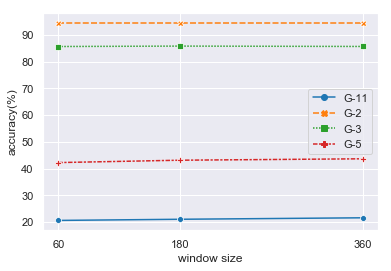

In [59]:
visual_effective_window_size(best_acc_df, score='test_acc', ylabel='accuracy(%)',
                            fname='../backup/effective_window_size.png')

### *.Evaluate scores over epoch

In [180]:
# columns = ['epoch']
# columns.extend(test_score_names)
# # select epoch having max accuracy
# data = df[(df.pretrained_path == 'F-0') & (df.los_group == 'G-5')][columns]
# data.set_index('epoch', inplace=True)
# data.sort_index(inplace=True)

# plt.subplots(figsize=(8, 5))
# sns_plot = sns.lineplot(data=data, palette="tab10")
# fig = sns_plot.get_figure()
# fig.show()